In [1]:
import json 
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.sql import text 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from sqlalchemy.orm import sessionmaker
from configparser import ConfigParser

In [2]:
config = ConfigParser()
config.read("database.conf")
config.sections()
host = config["drugdata"]["host"]
port = config["drugdata"]["port"]
database = config["drugdata"]["database"]
user = config["drugdata"]["user"]
password = config["drugdata"]["password"]
DATABASE_URL = f"postgresql://{user}:{password}@{host}:{port}/{database}"

engine = sqlalchemy.create_engine(DATABASE_URL)

In [3]:
# set up descriptors 

descriptors = [
    'compound_name', 
    'molecular_weight', 
    'clogp',
    'hbd',
    'hba',
    'psa',
    # 'apka',
    # 'aromatic_rings',
    # 'rotatable_bonds'
     
]

In [4]:
# retrieve data from database 

def get_data_for_group(group_token): 
    with engine.connect() as conn: 
        dataset = conn.execute(text("""
            WITH data AS
            (
                            SELECT DISTINCT bioavailability,
                                            compound_name,
                                            smiles,
                                            Lower(absorption) AS absorption,
                                            molecular_weight,
                                            clogp,
                                            aromatic_rings,
                                            hba,
                                            hbd,
                                            rotatable_bonds,
                                            psa,
                                            bpka,
                                            apka
                            FROM            curated.compound
                            WHERE           Lower(absorption) LIKE '%bioavailability%'
                            AND             Lower(absorption) LIKE '%oral%'
                            AND             atc_code like :group_token
                            ), 

            data2 AS
            (
                   SELECT substring(absorption from 'bioavailability [a-z. (0-9]+ [0-9.]+%') v1,
                          substring(absorption FROM 'bioavailability [a-z. (]+ [0-9.%]+')    v2,
                          substring(absorption FROM 'bioavailability .+ [0-9.]+%')           v3,
                          absorption,
                          *
                   FROM   data)
            SELECT*
            FROM   data2 
            where molecular_weight is not null 
            AND molecular_weight::float < 1000

            AND clogp is not null 
            
            AND hba is not null 
            AND hbd is not null 
            AND psa is not null 
            -- AND apka is not null 
            -- AND aromatic_rings is not null 
            -- AND rotatable_bonds is not null 
        """), {"group_token": group_token})

    data = [dict(row) for row in dataset]
    df = pd.DataFrame(data)
    assert (len(df["compound_name"].unique()) == len(df["compound_name"])), "Duplicated compound name"

    return df 


def get_best_ba_guess(row): 
    retval = None 
    v1 = row["v1"]
    try: 
        v1_list = v1.split(" ")
        perc_str = v1_list[len(v1_list)-1]
        if "%" in perc_str:
            perc_str = float(perc_str.replace("%", ""))
        retval = perc_str
    except AttributeError: 
        retval = None 
    return retval


def make_modeling_data(df): 
    modeling_data = df[df["perc_ba"].notnull()]

    for descriptor in descriptors: 
        if descriptor == 'compound_name': 
            continue 

        modeling_data[descriptor] = modeling_data[descriptor].apply(pd.to_numeric, errors="coerce")

    y = modeling_data["perc_ba"]
    X = modeling_data[descriptors]
    X = X.set_index("compound_name")
    return (X, y, modeling_data)

Therapeutic Group %


C:\Users\Lu Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


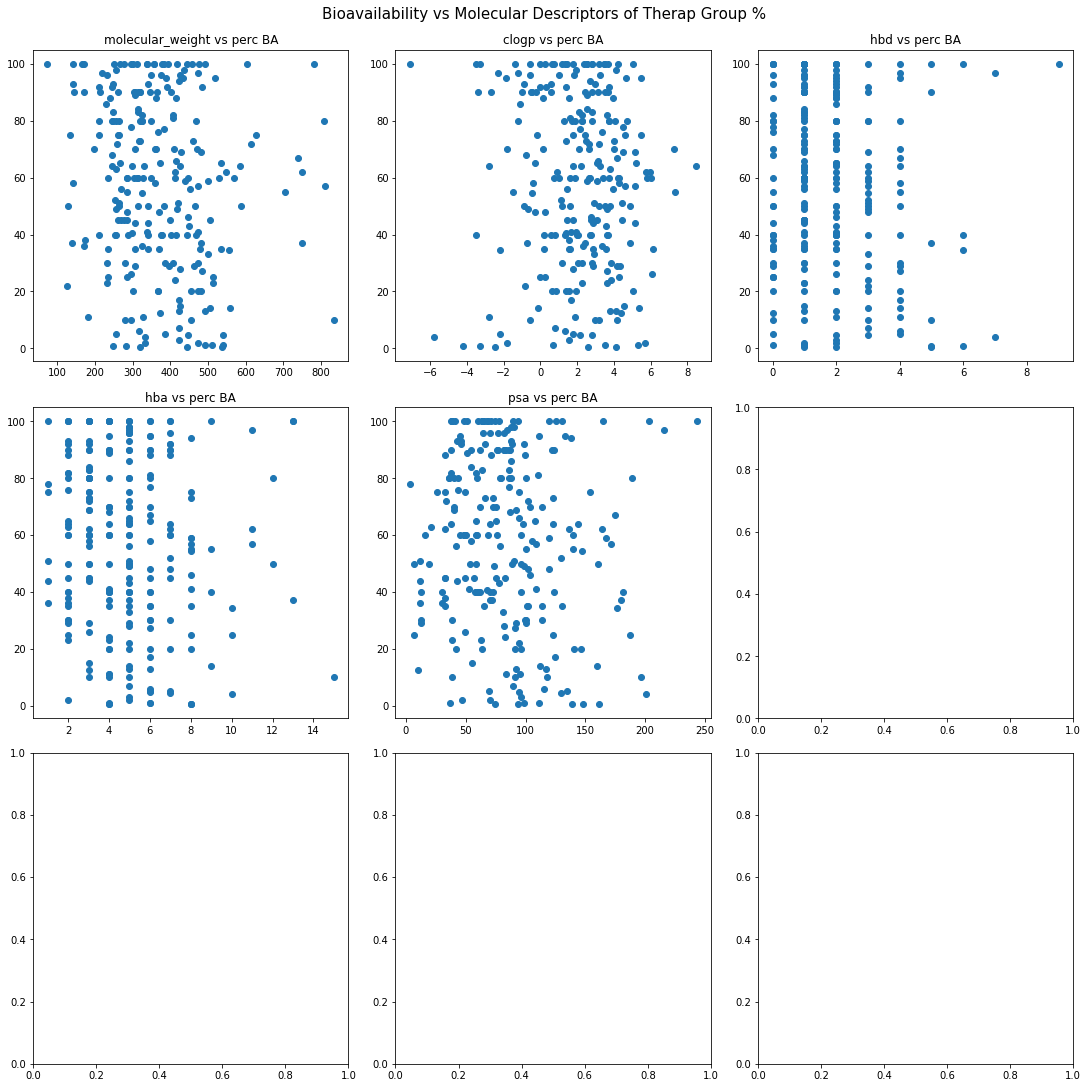

Therapeutic Group J%


C:\Users\Lu Wang\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


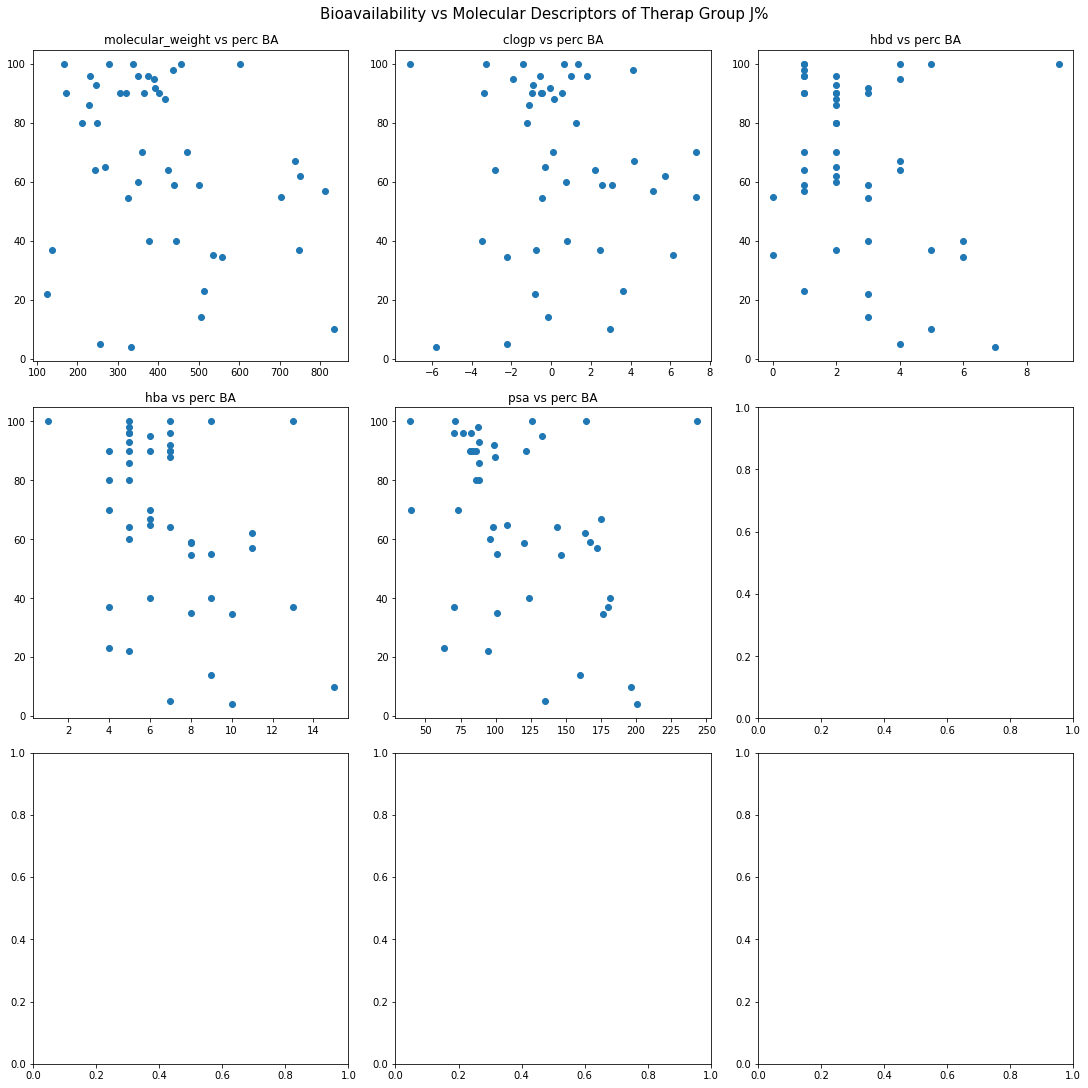

In [5]:
# go through all therapeutic groups 
models = {} 

thera_groups = ['%', 'A%', 'B%', 'C%', 'D%', 'G%','J%','L%','M%','N%','P%','R%', 'S%', 'V%']
thera_groups = ['%', 'J%']
for thera_group in thera_groups: 
    print(f"Therapeutic Group {thera_group}")
    df = get_data_for_group(thera_group)

    
    assert (len(df["compound_name"].unique()) == len(df["compound_name"])), "Duplicated compound name"

    df["perc_ba"] = np.nan 
    for index, row in df.iterrows():     
        df.at[index, "perc_ba"] = get_best_ba_guess(row)
    
    X, y, modeling_data =  make_modeling_data(df)
    
    reg = LinearRegression().fit(X, y)
    score = reg.score(X, y)
    sample_size = y.count() 

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), constrained_layout=True)
    list_o_axes = axes.flatten()
    fig.suptitle(f"Bioavailability vs Molecular Descriptors of Therap Group {thera_group}", fontsize=15)

    
    i =0 
    for descriptor in descriptors: 
        if descriptor == 'compound_name': 
            continue
            
        ax = list_o_axes[i]
        ax.scatter(modeling_data[descriptor], modeling_data["perc_ba"])
        ax.set_title(f"{descriptor} vs perc BA")
        i+=1 
    plt.show()
    
    models[thera_group] = {"model": reg, "score": score, "sample_size": sample_size}

In [7]:
model_coef_data = [] 
for key, model in models.items(): 
    score = model.get("score")
    sample_size = model.get("sample_size")
    model = model.get("model")
    coef_dict = dict(zip(descriptors[1:], model.coef_))
    coef_dict["group"] = key
    coef_dict["score"] = score
    coef_dict["sample_size"] = sample_size
    model_coef_data.append(coef_dict)
    
coef_df = pd.DataFrame(model_coef_data)
coef_df = coef_df.set_index("group")

valid_models = coef_df[coef_df["sample_size"] > 40]
valid_models 

,clogp,hba,hbd,molecular_weight,psa,sample_size,score
group,,,,,,,
%,-0.057768,-0.110117,-3.088058,-0.042223,0.082371,243,0.035597
J%,-9.378364,-4.344939,-7.438796,0.140192,-0.294024,46,0.316666
